In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import io
import zipfile

file_path = '/content/drive/MyDrive/bangkit/Arsip.zip'

zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall('/content/dataset/kualitas_buah')
zip_ref.close()

In [3]:
train_dir = '/content/dataset/kualitas_buah/Salinan train'

test_dir = '/content/dataset/kualitas_buah/Salinan test'

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width = 224
img_height = 224
batch_size = 32

augmentation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

normal_datagen = ImageDataGenerator(
    rescale=1./255
)

train_ds = augmentation_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_ds = augmentation_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_ds = normal_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [5]:
class_names = train_ds.class_indices
print(class_names)

{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [6]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(img_width, img_height, 3)
)

for layer in base_model.layers:
  layer.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_ds.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
273/273 [==============================] - 226s 776ms/step - loss: 0.2067 - accuracy: 0.9269 - val_loss: 0.0542 - val_accuracy: 0.9830
Epoch 2/100
273/273 [==============================] - 196s 718ms/step - loss: 0.0686 - accuracy: 0.9768 - val_loss: 0.0346 - val_accuracy: 0.9871
Epoch 3/100
273/273 [==============================] - 196s 717ms/step - loss: 0.0472 - accuracy: 0.9830 - val_loss: 0.0362 - val_accuracy: 0.9881
Epoch 4/100
273/273 [==============================] - 193s 709ms/step - loss: 0.0420 - accuracy: 0.9856 - val_loss: 0.0173 - val_accuracy: 0.9954
Epoch 5/100
273/273 [==============================] - 196s 719ms/step - loss: 0.0307 - accuracy: 0.9883 - val_loss: 0.0099 - val_accuracy: 0.9968
Epoch 6/100
273/273 [==============================] - 196s 718ms/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 0.0127 - val_accuracy: 0.9963
Epoch 7/100
273/273 [==============================] - 193s 709ms/step - loss: 0.0226 - accuracy: 0.9914 - val_loss: 0

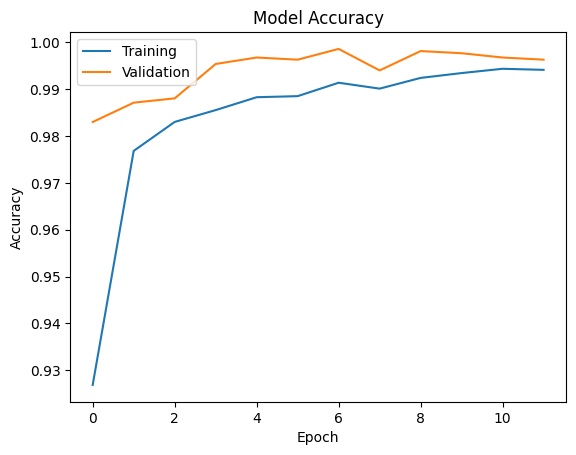

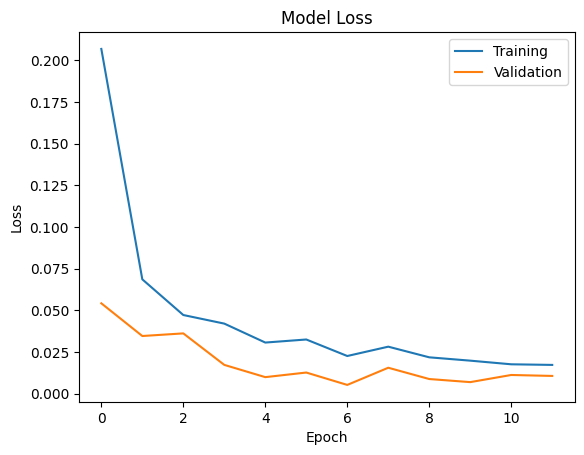

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [12]:
scores = model.evaluate(test_ds)

print('Akurasi: %.2f%%' % (scores[1] * 100))

85/85 [==============================] - 24s 282ms/step - loss: 0.0261 - accuracy: 0.9900
Akurasi: 99.00%


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = test_ds.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_ds.class_indices.keys())

85/85 [==============================] - 25s 282ms/step


In [14]:
print(cm)

[[388   0   0   6   0   1]
 [  0 381   0   0   0   0]
 [  0   0 374   3   0  11]
 [  2   0   1 598   0   0]
 [  0   0   0   0 530   0]
 [  0   0   1   2   0 400]]


In [15]:
print(cr)

               precision    recall  f1-score   support

  freshapples       0.99      0.98      0.99       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       0.99      0.96      0.98       388
 rottenapples       0.98      1.00      0.99       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       0.97      0.99      0.98       403

     accuracy                           0.99      2698
    macro avg       0.99      0.99      0.99      2698
 weighted avg       0.99      0.99      0.99      2698



Saving test14.jpg to test14.jpg
1/1 [==============================] - 0s 27ms/step


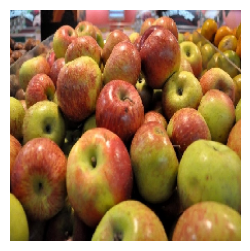

test14.jpg is a fresh apple

[9.3390101e-01 6.6955115e-05 6.9457275e-04 6.5309986e-02 1.8706398e-05
 8.8331426e-06]
[93.39, 0.007, 0.069, 6.531, 0.002, 0.001]


In [29]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  img = tf.keras.utils.load_img(fn, target_size=(224, 224))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  if classes[0][0]>0.5:
    prediction = 'fresh apple'
  elif classes[0][1]>0.5:
    prediction = 'fresh banana'
  elif classes[0][2]>0.5:
    prediction = 'fresh orange'
  elif classes[0][3]>0.5:
    prediction = 'rotten apple'
  elif classes[0][4]>0.5:
    prediction = 'rotten banana'
  elif classes[0][5]>0.5:
    prediction = 'rotten orange'

  plt.figure(figsize=(3,3))
  plt.imshow(tf.keras.utils.load_img(fn, color_mode="rgb", target_size=(224, 224), interpolation="nearest"))

  plt.axis('off')
plt.show()
print('{} is a {}'.format(fn,prediction))
print()
print(classes[0])
print([float(np.round(x * 100, decimals=3)) for x in classes[0]])